# Aim: 
The Framingham heart disease data set consists of various data points on the health parameters of humans and their 10 year history on having a cardiovascular disease event (https://framinghamheartstudy.org/). Here, the features on the health are used to predict via different machine learning algorithms and a neural network if an individual will suffer from a cardiovascular disease event.  

# import modules

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

from scipy import stats

from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.svm import SVC

from sklearn.naive_bayes import GaussianNB

from tensorflow.python.keras.layers import Input, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import History
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

#from tf.keras import Sequential
#from keras.layers import Dense
#from keras.callbacks import History 
history = History()

In [46]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/framingham-heart-study-dataset/framingham.csv


# ETL - extract, transform, load data

In [47]:
df = pd.read_csv("../input/framingham-heart-study-dataset/framingham.csv")

# Data exploration

In [48]:
df.head(2)

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0


In [49]:
df.shape

(4240, 16)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


## comment on table above:
- The data is already numeric which is good for the ML appraoch. There are some null values in the data which need to be fixed before

# Some Data Quality Assessment 

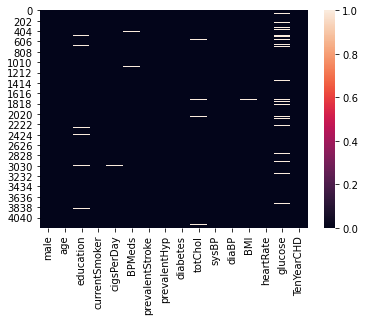

In [51]:
sns.heatmap(df.isna())

## comment on figure above:
- Overall Quality of the data is very good - not much cleansing is needed
- Most NAs are found in the glucose feature

## fill NAs 
- We take the median of the feature to fill the NAs

In [52]:
def fillnawithmedian(df, col):
    new_median = df[col].median()
    df[col][df[col].isna()] = new_median

In [53]:
for column in df.columns:
    print(column, "column has NAs and gets fixed:  \t", df[column].isnull().values.any())
    fillnawithmedian(df = df, col = column)

male column has NAs and gets fixed:  	 False
age column has NAs and gets fixed:  	 False
education column has NAs and gets fixed:  	 True
currentSmoker column has NAs and gets fixed:  	 False
cigsPerDay column has NAs and gets fixed:  	 True
BPMeds column has NAs and gets fixed:  	 True
prevalentStroke column has NAs and gets fixed:  	 False
prevalentHyp column has NAs and gets fixed:  	 False
diabetes column has NAs and gets fixed:  	 False
totChol column has NAs and gets fixed:  	 True
sysBP column has NAs and gets fixed:  	 False
diaBP column has NAs and gets fixed:  	 False
BMI column has NAs and gets fixed:  	 True
heartRate column has NAs and gets fixed:  	 True
glucose column has NAs and gets fixed:  	 True
TenYearCHD column has NAs and gets fixed:  	 False


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# check if there are NAs left in the data set

In [54]:
for column in df.columns:
    print(df[column].isnull().values.any())

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


# Check the data set if there are floats for a binary classification, in case there are change them to integers

In [55]:
for i in df.columns:
    if (sum(df[i].isin([0,1])) == df.shape[0]) & (df[i].dtype == "int64"):
        print("class1 binary:",i + " has two categories" + " and is dtype int64")
    if (sum(df[i].isin([0,1])) == df.shape[0]) & ~(df[i].dtype == "int64"):
        print("--")
        print("class2 binary:",i + " has two categories" + " and is not dtype int64")
        print("--")
    if ~(sum(df[i].isin([0,1])) == df.shape[0]) & (df[i].dtype == "int64"):
        print("--")
        print("class3 not binary:",i + " has more than two categories" + " and is dtype int64")
        print("--")

class1 binary: male has two categories and is dtype int64
--
class3 not binary: age has more than two categories and is dtype int64
--
class1 binary: currentSmoker has two categories and is dtype int64
--
class2 binary: BPMeds has two categories and is not dtype int64
--
class1 binary: prevalentStroke has two categories and is dtype int64
class1 binary: prevalentHyp has two categories and is dtype int64
class1 binary: diabetes has two categories and is dtype int64
class1 binary: TenYearCHD has two categories and is dtype int64


In [56]:
df.BPMeds.value_counts()

0.0    4116
1.0     124
Name: BPMeds, dtype: int64

In [57]:
df.BPMeds = df.BPMeds.astype(int)

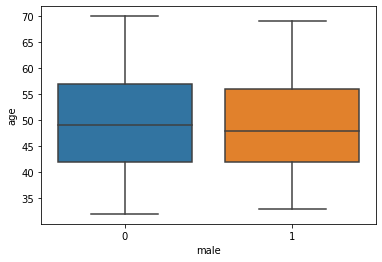

In [58]:
sns.boxplot(y = df.age, x = df.male)
#sns.swarmplot(y = df.age, x = df.male, color = ".3")


In [59]:
print("in this study are " + str(df.male.value_counts()[0]) + " women, and " +  str(df.male.value_counts()[1]) + " men")

in this study are 2420 women, and 1820 men


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff7c71d090>,
      dtype=object)

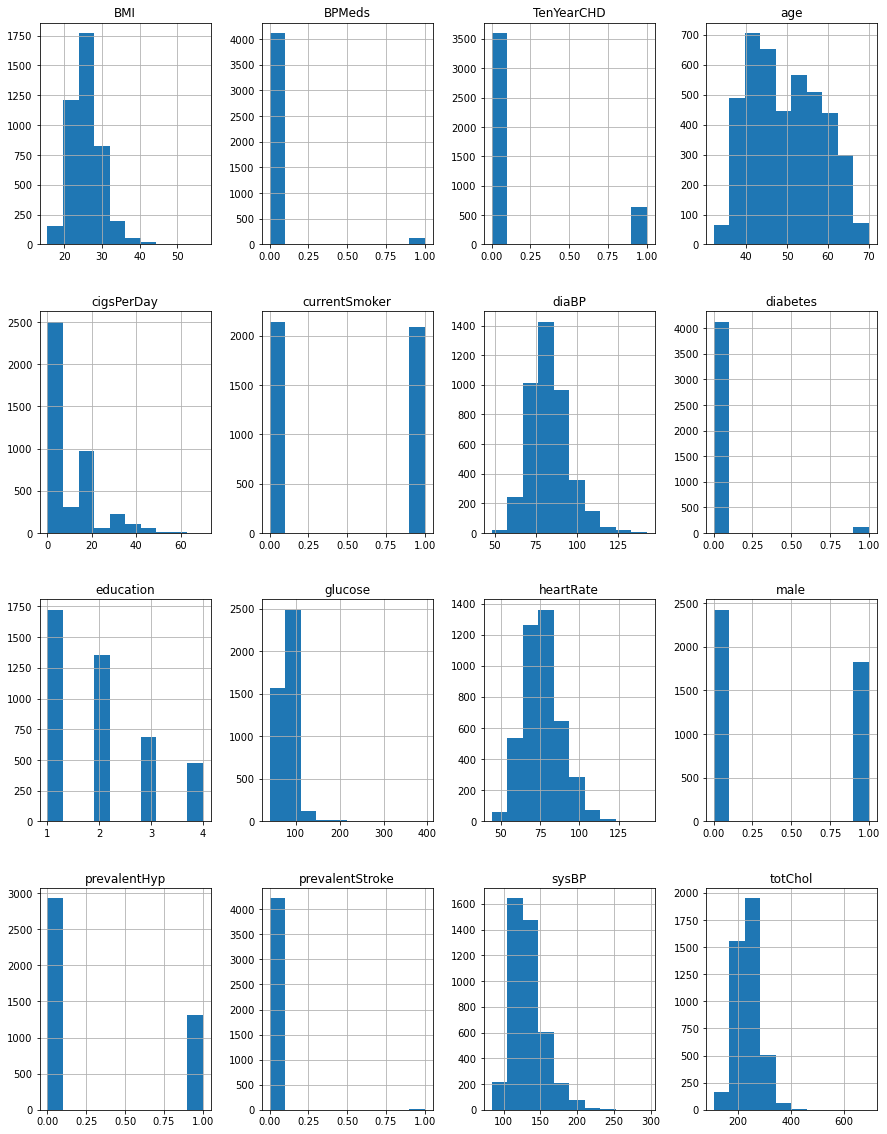

In [60]:
# checking distributions using histograms
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.hist(ax = ax)

# comment on figure above: 
- Most of the non-binary values are about normal distributed, and fine, without abnormalities. Glucose and total Cholesterol and BMI might have some outlier which might need to be removed. 

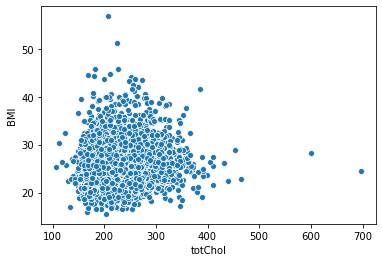

In [61]:
sns.scatterplot(df.totChol, df.BMI)

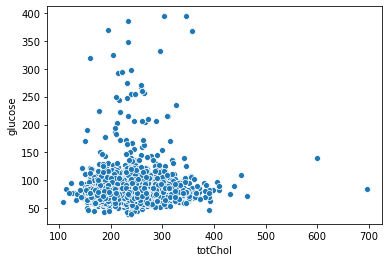

In [62]:
sns.scatterplot(df.totChol, df.glucose)

# comment on figures above: 
- those two outliers with a total Cholesterol of about 600 and 700 will be removed from further analysis. High levels are above 240mg/ dL (https://www.cdc.gov/nchs/fastats/cholesterol.htm). > 600 seems way above the risk level. I wil check however by zscore if those are also detected as outliers if the zscore is above 6

## detection and removal of outliers based on zscore 
- Take here a cutoff of 6 std deviations on the cholesterol levels

In [63]:
# search for outliers:
z = np.abs(stats.zscore(df.totChol))
df = df.iloc[np.where(z < 6)]

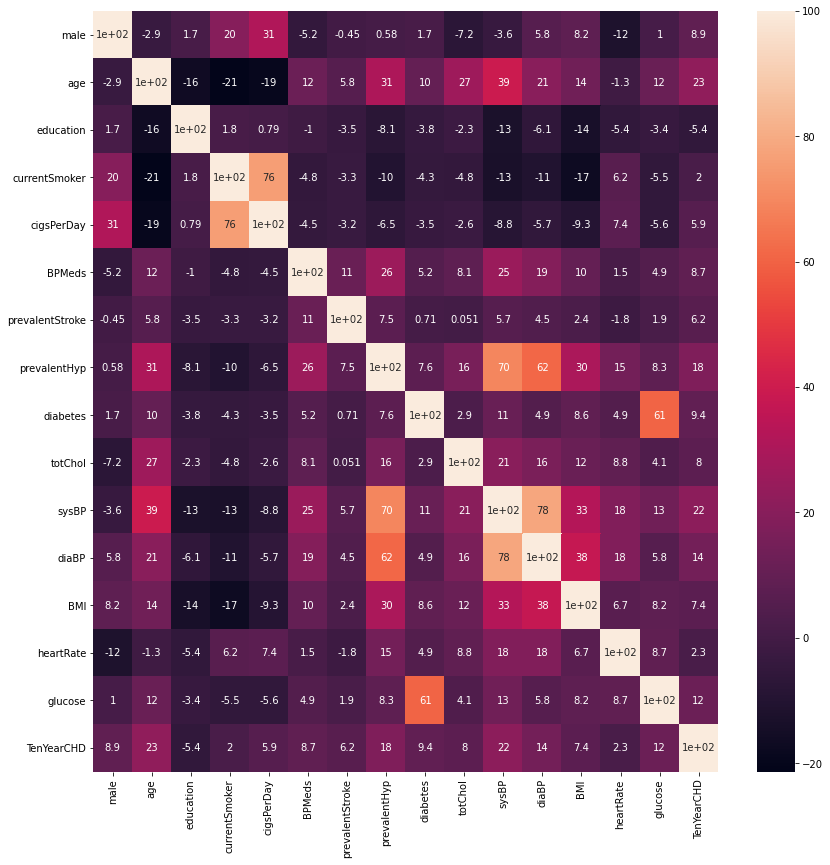

In [64]:
plt.figure(figsize = (14,14))
sns.heatmap(df.corr()*100, annot=True)

# comment on figure above:
- kind of a sanity check of the data. Correlations are observed for glucose levels and diabetes, systolic and diastolic blood pressure, smoker and amount of cigarettes. Correlations seem reasonable

# explore how the numbers are distributed between the genders and how many disease prediction we have in the dataset

In [65]:
pd.crosstab(df.male, df.TenYearCHD)

TenYearCHD,0,1
male,,
0,2119,300
1,1476,343


# comment on table above: 
- Male and female cases are about equally distributed for the ten year CHD event. However there are fewer cases for non CHD events for females.  
- The CHD event and non event are very unequally distributed. This has to be considered for the model

# --------

# end of data exploration 

# --------


# start with data transformation for machine learning and design different model

## scaling

In [66]:
mm_scaler = preprocessing.MinMaxScaler()
df_scaled = mm_scaler.fit_transform(df)

In [67]:
df_scaled = pd.DataFrame(df_scaled)

In [68]:
df_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.0,0.184211,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.246499,0.106383,0.232804,0.277024,0.363636,0.104520,0.0
1,0.0,0.368421,0.333333,0.0,0.000000,0.0,0.0,0.0,0.0,0.400560,0.177305,0.349206,0.319680,0.515152,0.101695,0.0
2,1.0,0.421053,0.000000,1.0,0.285714,0.0,0.0,0.0,0.0,0.386555,0.208038,0.338624,0.237518,0.313131,0.084746,0.0
3,0.0,0.763158,0.666667,1.0,0.428571,0.0,0.0,1.0,0.0,0.330532,0.314421,0.497354,0.316045,0.212121,0.177966,1.0
4,0.0,0.368421,0.666667,1.0,0.328571,0.0,0.0,0.0,0.0,0.498599,0.219858,0.380952,0.183228,0.414141,0.127119,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,0.0,0.421053,0.333333,1.0,0.285714,0.0,0.0,0.0,0.0,0.394958,0.224586,0.253968,0.156568,0.404040,0.129944,0.0
4234,0.0,0.315789,0.000000,1.0,0.214286,0.0,0.0,0.0,0.0,0.288515,0.203310,0.412698,0.087736,0.424242,0.107345,0.0
4235,0.0,0.526316,0.333333,0.0,0.000000,0.0,0.0,0.0,0.0,0.453782,0.236407,0.370370,0.143723,0.363636,0.189266,0.0
4236,1.0,0.210526,0.666667,0.0,0.000000,0.0,0.0,1.0,0.0,0.218487,0.271868,0.529101,0.243820,0.232323,0.090395,0.0


# balance out the negative and positive predictions:
    one problem we are running in here is that the distribution between positive and negative cases are heavily unbiased in a ratio of 5:1 of negative to postive cases
    thus we need to equal that out. Otherwise we get tricked into the point that we believe our ML classifier is good, but only predicts the predominant class, which is majority1

In [69]:
shuffled_df = df_scaled.sample(frac=1,random_state=4)


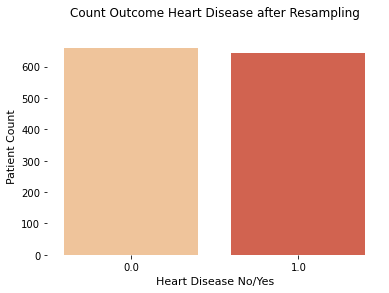

In [70]:
# Shuffle df
shuffled_df = df_scaled.sample(frac=1,random_state=4)

# Put all the fraud class in a separate dataset. # 643 hits
CHD_df = shuffled_df[shuffled_df.iloc[:,15] == 1]

#Randomly select 700 observations from the non-fraud (majority class)
non_CHD_df = shuffled_df[shuffled_df.iloc[:,15] == 0].sample(n=660,random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([CHD_df, non_CHD_df])

# check new class counts
normalized_df.iloc[:,15].value_counts()

# plot new count
sns.countplot(normalized_df.iloc[:,15], palette="OrRd")
plt.box(False)
plt.xlabel('Heart Disease No/Yes',fontsize=11)
plt.ylabel('Patient Count',fontsize=11)
plt.title('Count Outcome Heart Disease after Resampling\n')
#plt.savefig('Balance Heart Disease.png')
plt.show()

## train test split

In [71]:
X_train, X_test, y_train, y_test = train_test_split(normalized_df.iloc[:,:-1], normalized_df.iloc[:,-1], test_size=0.3, random_state=42)

## scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [72]:
clf = svm.SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [73]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6521739130434783
Precision: 0.6721311475409836
Recall: 0.6180904522613065
              precision    recall  f1-score   support

         0.0       0.63      0.69      0.66       192
         1.0       0.67      0.62      0.64       199

    accuracy                           0.65       391
   macro avg       0.65      0.65      0.65       391
weighted avg       0.65      0.65      0.65       391



# comments on the classification report of SVM without GridSearch above
- recall value at 62%
- precision at 67%

# SVM with grid search

In [74]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf', "linear"], 'gamma': [0.01, 0.001, 0.0001],
                     'C': [1, 10, 100]}]

In [75]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

In [76]:
scores = ['precision', 'accuracy']


for score in scores:
    print()
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        SVC(), # support vector classifier 
        tuned_parameters, # see above
        cv=8 , # 5 cross validation steps 
        scoring='%s' % score 
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))



# Tuning hyper-parameters for precision



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined a

Best parameters set found on development set:

{'C': 10, 'gamma': 0.01, 'kernel': 'linear'}

Grid scores on development set:

0.637 (+/-0.133) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.655 (+/-0.078) for {'C': 1, 'gamma': 0.01, 'kernel': 'linear'}
0.000 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.655 (+/-0.078) for {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
0.000 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.655 (+/-0.078) for {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
0.658 (+/-0.070) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.663 (+/-0.077) for {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}
0.638 (+/-0.138) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.663 (+/-0.077) for {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}
0.000 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.663 (+/-0.077) for {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}
0.660 (+/-0.070) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.661 (+/-0.069) for {'C': 100

In [77]:
print("With following parameters",clf.best_params_, " we get the following scores:")

With following parameters {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}  we get the following scores:


In [78]:
y_true, y_pred = y_test, clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6521739130434783
Precision: 0.6521739130434783
Recall: 0.678391959798995
              precision    recall  f1-score   support

         0.0       0.65      0.62      0.64       192
         1.0       0.65      0.68      0.67       199

    accuracy                           0.65       391
   macro avg       0.65      0.65      0.65       391
weighted avg       0.65      0.65      0.65       391



# comments on the classification report of SVM with GridSearch above
- recall value at 68%
- precision at 65%

In [79]:
confusion_matrix(y_test, y_pred)

array([[120,  72],
       [ 64, 135]])

# SVM with grid search and cross validation:

Average difference of 0.007626 with std. dev. of 0.005730.


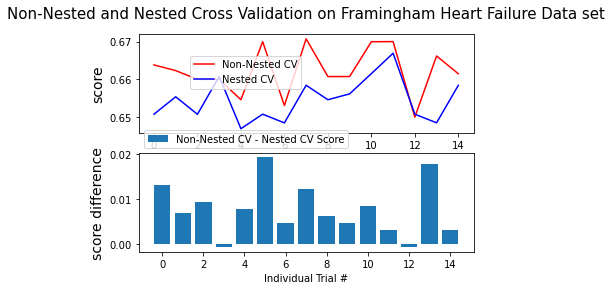

In [80]:
#### code adapted from here ####
## https://scikit-learn.org/0.20/auto_examples/model_selection/plot_nested_cross_validation_iris.html
#### 
# Number of random trials
NUM_TRIALS = 15

# Load the dataset
X_data = normalized_df.iloc[:,:-1]
y_target = normalized_df.iloc[:,-1]



# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 75],
          "gamma": [.01, .1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    clf.fit(X_data, y_target)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_data, y=y_target, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print("Average difference of {0:6f} with std. dev. of {1:6f}."
      .format(score_difference.mean(), score_difference.std()))

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"],
           bbox_to_anchor=(0, .4, .5, 0))
plt.title("Non-Nested and Nested Cross Validation on Framingham Heart Failure Data set",
          x=.5, y=1.1, fontsize="15")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("score difference", fontsize="14")

plt.show()

# Nested Cross Validation foes not improve the score significantly and is not used in this prediction models 

# Gaussian Classifier

## define the model

In [81]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test) 

In [82]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.578005115089514
Precision: 0.7023809523809523
Recall: 0.2964824120603015
              precision    recall  f1-score   support

         0.0       0.54      0.87      0.67       192
         1.0       0.70      0.30      0.42       199

    accuracy                           0.58       391
   macro avg       0.62      0.58      0.54       391
weighted avg       0.62      0.58      0.54       391



# comments on the classification report of Naive Bayes Gaussian Classifier above
- recall value at 30%
- precision at 70%

# Use a deep learning model by a sequential Keras model

## define the model

In [83]:
clf = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(15,)),
    tf.keras.layers.Dense(12, activation=tf.nn.relu),
    tf.keras.layers.Dense(12, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid),
])

clf.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss') # stop when overfitting occurs and the validation loss rises

## run the model

In [84]:
clf.fit(X_train, y_train ,epochs=30, 
        batch_size=1, 
        validation_data=(X_test, y_test), 
        callbacks=[history,es_callback]) # 


test_loss, test_acc = clf.evaluate(X_test, y_test)
y_pred = clf.predict(X_test)
print('Test accuracy:', test_acc)

Epoch 1/30
912/912 [==============================] - 2s 2ms/step - loss: 0.6831 - accuracy: 0.5636 - val_loss: 0.6695 - val_accuracy: 0.6138
Epoch 2/30
912/912 [==============================] - 2s 2ms/step - loss: 0.6598 - accuracy: 0.6206 - val_loss: 0.6473 - val_accuracy: 0.6292
Epoch 3/30
912/912 [==============================] - 2s 2ms/step - loss: 0.6433 - accuracy: 0.6382 - val_loss: 0.6463 - val_accuracy: 0.6445
Epoch 4/30
912/912 [==============================] - 1s 2ms/step - loss: 0.6346 - accuracy: 0.6491 - val_loss: 0.6376 - val_accuracy: 0.6138
Epoch 5/30
912/912 [==============================] - 1s 2ms/step - loss: 0.6285 - accuracy: 0.6469 - val_loss: 0.6372 - val_accuracy: 0.6471
Epoch 6/30
912/912 [==============================] - 1s 2ms/step - loss: 0.6220 - accuracy: 0.6623 - val_loss: 0.6289 - val_accuracy: 0.6419
Epoch 7/30
912/912 [==============================] - 1s 2ms/step - loss: 0.6181 - accuracy: 0.6612 - val_loss: 0.6287 - val_accuracy: 0.6343
Epoch 

## plot the model accuracy and loss function

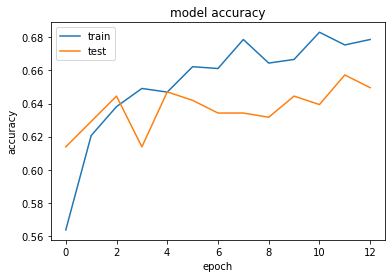

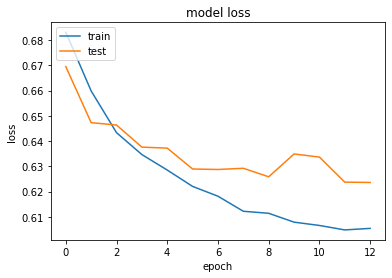

In [85]:
#print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [86]:
y_pred_t = pd.DataFrame(y_pred).apply(lambda x:  1 if x.values > 0.5 else 0 , axis = 1 )
y_pred_t.index = y_test.index

In [87]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_t))
print("Precision:",metrics.precision_score(y_test, y_pred_t))
print("Recall:",metrics.recall_score(y_test, y_pred_t))
print(classification_report(y_test, y_pred_t))

Accuracy: 0.649616368286445
Precision: 0.6270491803278688
Recall: 0.7688442211055276
              precision    recall  f1-score   support

         0.0       0.69      0.53      0.60       192
         1.0       0.63      0.77      0.69       199

    accuracy                           0.65       391
   macro avg       0.66      0.65      0.64       391
weighted avg       0.66      0.65      0.64       391



# comments on the classification report of Keras Sequential model above
- recall value at 77%
- precision at 63%

Best Threshold=1.000000, G-Mean=0.636


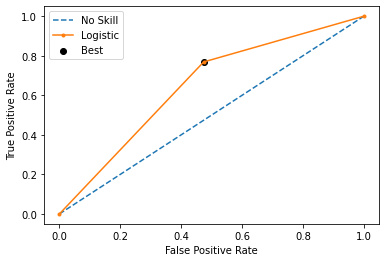

In [88]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_t)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()
#Running the example f

## Overview models used:

comments on the classification report of Keras Sequential model above
- recall value at 77%
- precision at 63%

comments on the classification report of Naive Bayes Gaussian Classifier above
- recall value at 30%
- precision at 75%


comments on the classification report of SVM without GridSearch above
- recall value at 58%
- precision at 66%

comments on the classification report of SVM with GridSearch above
- recall value at 64%
- precision at 67%


# Conclusion:
- Two machine learning and one neural network model were tested to predict the 10 year occurence of a cardiovascular event
- The recall value will be of high importance. We dont want to miss persons getting a CVD. Thus recall will rated highest.
- Hence, the Support Vector Machine Model with the Grid Search is the favored model here for predicting the 10 year cardiovascular disease event


# SVM with the Grid Search best model to predicting the 10 year cardiovascular disease event

## Appendix - Contact:
- https://www.linkedin.com/in/simon-baumgart-30281a8a/
- https://github.com/simjbaum/
> 